# Assignment 01 - Pitfalls in Data Mining     
## CSCI E-96

The goal of data mining is to find important relationships in large complex datasets. These dataset typically contain a large number of variables. The **high-dimensional** nature of the data leads to some commonly encountered pitfalls which lead to incorrect inferences.   

In this assignment you will gain a bit of experience with three important concepts in data mining:  

1. **False Discovery Rate Control:** The goal of data mining is to find important relationships in large complex datasets. These dataset typically contain a large number of variables. The **high-dimensional** nature of the data leads to some commonly encountered pitfalls which lead to incorrect inferences. A related problem is cutting off a large-scale analysis when a desired relationship is 'found'. This practice of **p-value mining** often leads to unwarranted inferences. You will apply false discovery rate (FDR) control methods to address this problem.   
2. **Key-Value Pairs:** Large scale data is typically managed using key-value (KV) pairs. The exercises in this assignment give you some experience working with KV pair data management.  
3. **Map and Reduce Processes:** Much of large scale data mining requires use of a split-apply-combine approach. The data is split into manageable chunks, analytic transformations are applied, and the result combined or aggregated. A commonly used class of a split-apply-combine algorithm is MapReduce. 

In order to keep the scope of this assignment manageable, you will use limited versions of KV pair management and MapReduce. Specifically, you will use common Python tools to implement these concepts rather than dedicated large scale analytic platforms. 

## Multiple Hypothesis Tesing

Testing multiple hypothesis in high-dimensional data can be problematic. Exhaustively testing all pairwise relationships between variables in a data set is a commonly used, but generally misleading from of **multiple comparisons**. The chance of finding false significance, using such a **data dredging** approach, can be surprisingly high. 

In this exercise you will perform multiple comparisons on only 20 **identically distributed independent (iid)** variables. Ideally, such tests should not find significant relationships, but the actual result is quite different. 

To get started, execute the code in the cell below to load the required packages. 

In [1]:
import pandas as pd
import numpy as np
import numpy.random as nr
from scipy.stats import ttest_ind, f_oneway
from itertools import product, combinations
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_rows", None, "display.max_columns", None)

In this exercise you will apply a t-test to all pairwise combinations of identical Normally distributed variables. In this case, we will create a data set with 20 iid Normal distributions of 1000 samples each. Execute the code in the cell below to find this data and display the mean and variance of each variable.  

In [2]:
ncolumns = 20
nr.seed(234)
normal_vars = nr.normal(size=(1000,ncolumns))
print('The means of the columns are\n', np.mean(normal_vars, axis = 0))
print('\nThe variances of the columns are\n', np.var(normal_vars, axis = 0))

The means of the columns are
 [-1.16191649e-01  2.80829317e-02 -1.78516419e-02 -1.44691489e-02
  3.03718152e-02  1.20007442e-02 -9.58845606e-05  1.98662580e-03
  4.94154934e-02 -4.11640866e-02 -6.32977862e-03 -5.93868192e-02
 -2.56373595e-02  1.43568791e-02 -1.44725765e-02 -1.37023955e-02
  1.80622439e-02  5.87029691e-02 -2.02650514e-02 -1.56346106e-02]

The variances of the columns are
 [0.94834508 1.04744241 1.0258018  0.96977571 1.0089001  1.04113864
 1.00657222 0.99192594 1.04713487 1.04329434 1.04023108 0.96791346
 1.03706907 1.07179865 1.01431404 1.05060289 1.02054329 0.9686211
 1.02810287 0.99521555]


Notice that means and variances are close to 0.0 and 1.0 respectively. As expected, there is not much difference between these variables.

How many of these t-tests will show **significance** at the 0.05 cut-off level? There are 380 pairwise combinations, so we expect to find a number of falsely significant test results at this level. To find out, complete and execute the code in the cell below to filter the test results and print those that show significance. 

### Creating a hash 

The goal of this exercise is to compute pairwise hypothesis tests of the differences in means for each of the iid Normal vectors. As an intermediate step you will create a Pandas data frame using a hash of the keys of the vectors. The data frame will contain the **key-value**, $(K,V)$, pairs. Each key must represent an index for the two vectors used to compute the test statistic. The keys will then be used to index the results of these hypothesis tests. 

The question is, how can we create a hash from the keys for the pair of vectors? In this case to we will use a simple, but far from optimal hash. For the two vector indicies $i, j$, for some key and modulo, $m$, we will compute the hash as:  

$$h(i,j) = (i + key*j) mod m$$

> **Computational Note:** The Pandas data frame is an efficient and reasonably scalable **hash table**. The hash function used depends on the type of the key; integer, string, etc. The resulting dictionary of key-value pairs, $(K,V)$, can therefore be access in far less than linear time, often about $O(log(N))$.  

If you are not familiar with Python dictionaries you can find a short tutorial [here](https://www.tutorialspoint.com/python_data_structure/python_hash_table.htm), as well as many other places on the web.

In [3]:
1024*32

32768

> **Exercise 1-1:** Given that our space of vectors is actually quite small, just 20, we do not need a sophisticated and scalable hash function. This hashed key will then be used to store and retrieve the values using a Python dictionary, in about $O(log(N))$ time.     

> In this exercise you will test a simple hash function and its inverse. Examine the code below and notice that the hash function encodes the two indexes into a single integer by simple additional and multiplication. The modulo operation limits the size of the hash table. However, to keep things simple you will not need to implement any hash collision resolution mechanism. As a result, the size of the table is set much larger than required.  

> To test this hash, do the following:    
> 1. Create a function called hash function to compute the hash. The arguments to the function are $i$ and $j$, the `hash\_key` and the `modulo\_multiplier`. The defaults of the arguments are $hash\_key=1024$ and $modulo\_multiplier=32$. The modulo number is $hash\_key * modulo\_multiplier$, e.g. $modulo = 32,768$. The multiplier is the ratio of expected values stored, $n$, to the number of unique hash keys, $m$, e.g. the ratio $m/n$.
> 2. Using the Python [ittertools.combinations](https://docs.python.org/3/library/itertools.html#itertools.combinations) function create all unique pairwise combinations of indexes i and j. The arguments to this function are the indexes to the iid Normal vectors. The iterator is `range(ncolumns)` choose 2, since these comparisons are pairwise.    
> 3. Within this loop call the hash with the values of $i$ and $j$ as arguments.   
> 3. On a single line print the following; the values of i and j, the hash key value, but only if $i \le 6$. The restriction is to keep the printed output shorter.   

In [4]:
def hash_function(i, j, hash_key=1024, modulo_multiplier=32):
    ## Put your code below. 
    modulo = hash_key * modulo_multiplier
    return (i + (j + 1) * hash_key) % modulo


for i,j in combinations(range(ncolumns), 2):
    if i < 6: 
        hash = hash_function(i,j)
        print('i = ' + str(i) + '  j = ' + str(j) + '   hash = ' + str(hash))

i = 0  j = 1   hash = 2048
i = 0  j = 2   hash = 3072
i = 0  j = 3   hash = 4096
i = 0  j = 4   hash = 5120
i = 0  j = 5   hash = 6144
i = 0  j = 6   hash = 7168
i = 0  j = 7   hash = 8192
i = 0  j = 8   hash = 9216
i = 0  j = 9   hash = 10240
i = 0  j = 10   hash = 11264
i = 0  j = 11   hash = 12288
i = 0  j = 12   hash = 13312
i = 0  j = 13   hash = 14336
i = 0  j = 14   hash = 15360
i = 0  j = 15   hash = 16384
i = 0  j = 16   hash = 17408
i = 0  j = 17   hash = 18432
i = 0  j = 18   hash = 19456
i = 0  j = 19   hash = 20480
i = 1  j = 2   hash = 3073
i = 1  j = 3   hash = 4097
i = 1  j = 4   hash = 5121
i = 1  j = 5   hash = 6145
i = 1  j = 6   hash = 7169
i = 1  j = 7   hash = 8193
i = 1  j = 8   hash = 9217
i = 1  j = 9   hash = 10241
i = 1  j = 10   hash = 11265
i = 1  j = 11   hash = 12289
i = 1  j = 12   hash = 13313
i = 1  j = 13   hash = 14337
i = 1  j = 14   hash = 15361
i = 1  j = 15   hash = 16385
i = 1  j = 16   hash = 17409
i = 1  j = 17   hash = 18433
i = 1  j = 18   h

> Examine the key pairs and the hash values. The question is, are there any hash collisions? This can be done as follows:   
> 5. Compute a list of the hash values for all combinations of $i$ and $j$.   
> 6. Print the length of the list.  
> 7. Print the length of the unique values of the hash. You can find the unique values in a list with the [numpy.unique](https://numpy.org/doc/stable/reference/generated/numpy.unique.html) function. 

In [5]:
## Put your code below. 
hash_list = [hash_function(i,j) for i,j in combinations(range(ncolumns), 2)]
print(len(hash_list))
print(len(np.unique(hash_list)))

190
190


> Examine the results you have printed. Is there any evidence of hash key collisions?     
> The ratio of $m/n$ is deliberately kept high since the simple hash function has no collision resolution mechanism. Optionally, you can try reducing this ration (the multiplier) to 16 and 8, noting the increase in hash collisions.  
> **End of exercise.**

### The map process

We are constructing this example a map and a reduce process. The processes are intended to compute the hypothesis test for differences of means between all the pairs of vectors. The first step is the map process, which creates the keys, or values of $i$ and $j$ for these pairs.   

> **Exercise 1-2:** You will now create the code for the map task which build a data frame with $i, j$ key pairs indexed by the hash. By the following steps you will create code that represents a map task.  
> 1. Create a data frame with two columns $i$ and $j$ with rows $= hash_key * modulo_multiplier $ and set all values to $= numpy.nan$.
> 2. Create a loop over all combinations of the pairs of i and j.   
> 2. Compute the hash key value for the indexes, i and j.  
> 4. Add the $i$ and $j$ values to the row indexed by the hash key.  
> 5. Return the hash table. 
> 6. Execute the function to create the hash table.  
> 7. Compute and print the length of the hash table. 

In [6]:
def map_hypothesis(vars, hash_key=1024, modulo_multiplier=32):
    ## Put your code below. 
    ncolumns = vars.shape[1]
    nhash = hash_key * modulo_multiplier 
    hash_table = pd.DataFrame({'i':[np.nan]*nhash, 'j':[np.nan]*nhash})
    for i,j in combinations(range(ncolumns), 2): 
        ## Put your code below. 
        ## Compute the hash key and added the values to the 
        ## row of the data frame. 
        hash_key = hash_function(i,j)
        hash_table.iloc[hash_key,:] = [i,j]
    return hash_table

hash_table = map_hypothesis(normal_vars)

> **End of exercise.**

### The shuffle and reduce task

Now that you have the keys for the pairwise combinations of the vectors it is time to perform the reduce process. The reduce process computes the pair-wise t-statistics and p-values. These statistical values are indexed by the keys of the pair of vectors. This process reduces the full vectors of values down to just two numbers for each pair of vectors. 

> **Exercise 1-3:** You will now create and apply the following code for the reduce process:   
> 1. Create an empty data frame with columns, `i`, `j`, `t_statistic`, and `p_value`.    
> 2. Using a for loop iterate over all possible (hashed) keys of the data frame. An if statement is used to test if these are valid values of the key, i. Use the [numpy.isnan](https://numpy.org/doc/stable/reference/generated/numpy.isnan.html) function for this test.  
> 3. Extract the values of i and j from the input data frame. 
> 4. Using keys, compute the t-statistic and p-value using [scipy.stats import ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html).
> 5. Append a row to the output data frame.
> 6. Return the data frame, sorted in ascending order, using the [Pandas.DataFrame.sort_values](https://turned.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html) method and re-indexed using the [Pandas.DataFrame.reset_index](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html) method.    
> 7. Execute your function and save the returned data frame.

In [7]:
def reduce_significance(hash_table, values):  
    ## Create a data framreturn the results of the 
    ## the reduce process. The results are grouped by the first 
    ## index i. 
    test_results = pd.DataFrame(columns=['i','j','t_statistic','p_value'])

    ## As a substitute for a shuffle we will use a simple search 
    ## through the data frame  
    for hash in range(hash_table.shape[0]): 
    ## Put your code below. 
        if not np.isnan(hash_table.iloc[hash,0]):
            i = int(hash_table.iloc[hash,0]) 
            j = int(hash_table.iloc[hash,1])
            
    ## Given the i,j pairs we need to compute the t-statistic and the p-value.   
    ## This is the reduce step, since for each i,j pair there is only 
    ## a t-statistic and a p-value. 
    ## Put your code below. 
            t_statistic, p_value = ttest_ind(values[:,i],values[:,j])
            test_results = test_results.append({'i':i, 'j':j, 't_statistic':t_statistic, 'p_value':p_value}, ignore_index=True)
    ## Sort and return the results
    #test_results.sort_values('p_value', axis=0, ascending=True# , inplace=True)
    return test_results.sort_values('p_value', axis=0, ascending=True).reset_index(drop=True)        
        

test_stats = reduce_significance(hash_table, normal_vars)       

In [27]:
test_stats.head()

,i,j,t_statistic,p_value
0,0.0,17.0,-3.992565,0.000068
1,0.0,8.0,-3.705426,0.000217
2,0.0,4.0,-3.311203,0.000946
3,0.0,1.0,-3.227865,0.001267
4,0.0,16.0,-3.024120,0.002525


> 8. In the cell below, create a filter for pair test cases which are significant and save these cases in a data frame. 
> 9. Print the number (len) of significant results.
> 10. Print the rows with the significant test results.

In [8]:
significance_level = 0.05
## Put your code below. 
significant_tests = test_stats[test_stats.iloc[:,3] < significance_level]
print(len(significant_tests))
print(significant_tests)

22
       i     j  t_statistic   p_value
0    0.0  17.0    -3.992565  0.000068
1    0.0   8.0    -3.705426  0.000217
2    0.0   4.0    -3.311203  0.000946
3    0.0   1.0    -3.227865  0.001267
4    0.0  16.0    -3.024120  0.002525
5    0.0  13.0    -2.903111  0.003735
6    0.0   5.0    -2.872598  0.004114
7   11.0  17.0    -2.682146  0.007375
8    0.0   7.0    -2.681570  0.007388
9    0.0   6.0    -2.624430  0.008746
10   0.0  10.0    -2.462400  0.013885
11   8.0  11.0     2.422580  0.015499
12   0.0   3.0    -2.321463  0.020362
13   0.0  14.0    -2.294894  0.021842
14   0.0  15.0    -2.291186  0.022056
15   0.0  19.0    -2.279797  0.022725
16   9.0  17.0    -2.225359  0.026168
17   0.0   2.0    -2.212194  0.027066
18   0.0  18.0    -2.156647  0.031152
19   0.0  12.0    -2.031263  0.042360
20   4.0  11.0     2.017791  0.043747
21   8.0   9.0     1.980137  0.047825


> Notice the large number of apparently significant tests. Answer the following questions:  
> 1. Is the number of false positive cases higher than expected?    
> 2. Examine which of the iid Normal vectors contribute to the false positive results. Are there vectors which contribute multiple times?   
> **End of exercise.**

### Bonferroni correction  

Several adjustments to the multiple comparisons problem have been proposed. In Dunn published a method know as the **Bonferroni correction** in 1961. The Bonferroni correction is a widely used method to reduce the false positive rate of hypothesis tests.  The adjustment is simple:
$$\alpha_b = \frac{\alpha}{m}\\
with\\ 
m =\ number\ of\ groups$$

Can the Bonferroni correction help? Yes, by greatly increasing the confidence level required for a statistically significant result. The problem with the Bonferroni correction is the reduction in power as the  grows smaller. For big data problems with large numbers of groups, this issue can be especially serious. 

**Exercise 1-4:** You will now apply the Bonferroni correction to the iid Normal vectors. To do so, :   

In [9]:
significance_bonferroni = significance_level/190.0
significant_tests = test_stats[test_stats.iloc[:,3] < significance_bonferroni]
len(significant_tests)            

2

> Even with the Bonferroni correction we have some false significance tests, if only just barely!    
> **End of exercise.**

But, can we detect small effect with Bonferroni correction, as this method significantly reduces power of tests? Execute the code in the cell below, which compares a standard Normal to a Normal with a small mean (effect size), to find out. 

In [10]:
nr.seed(567)
print(significance_bonferroni)
ttest_ind(normal_vars[:,0], nr.normal(loc = 0.01, size=(1000,1)))

0.0002631578947368421


Ttest_indResult(statistic=array([-2.49553488]), pvalue=array([0.01265684]))

Given the Bonferroni correction, this difference in means would not be found significant. This illustrates the downside of the correction, which may prevent detection of significant effects, while still finding false significance. 

## False Discovery Rate Control Methods 

We have seen the potential pitfalls of multiple hypothesis testing. Further, we have seen that a simple approach to **false discovery rate (FDR) control** is not effective. You will now apply more sophisticated FDR control methods to control the FDR. 

The specific problem we will explore is to determine which genes lead to expression of a certain disease. In this example, there are gene expression data for 97 patients. Some of these patients have ulcerative colitis and others have Crohn's disease, which is believed to be genetically inherited.    

One approach to this problem is to perform hypothesis tests on the expression of the genes between patients with the two conditions. Since there are over 10,000 genes there is considerable chance for false discovery. Therefore, careful application of FDR control is required.

To continue with the example, execute the code in the cell below to load the data and print the dimensionality of the data frame. 

In [13]:
gene_data = pd.read_csv('../data/ColonDiseaseGeneData-Cleaned.csv')
print(gene_data.shape)

(97, 10498)


There are data from 97 patients for 10,497 genes. A large number of hypothesis tests are required!     

Execute the code in the cell below to view the first 5 columns of the data frame, which includes the expression of the first 4 genes.  

In [14]:
 print(gene_data.iloc[:,:5])      

              Disease State  FAM138F  LOC100133331  LOC100132062  LOC388312
0   Ulcerative Colitis (UC)   7.2980        8.5650        8.7778     9.2365
1   Ulcerative Colitis (UC)   8.0751        8.3536        8.7785     9.4256
2   Ulcerative Colitis (UC)   6.8458        8.8254        9.1960     9.8835
3   Ulcerative Colitis (UC)   7.6507        8.1838        8.2845     8.8011
4   Ulcerative Colitis (UC)   7.3524        8.4415        8.6630     9.1292
5   Ulcerative Colitis (UC)   7.2811        8.4023        8.6892     9.3487
6   Ulcerative Colitis (UC)   7.8913        8.8026        8.6892     8.4706
7   Ulcerative Colitis (UC)   7.0641        8.5498        8.7145     9.0538
8   Ulcerative Colitis (UC)   7.5266        8.8004        9.1334     9.8241
9   Ulcerative Colitis (UC)   7.0322        8.8119        9.1838     9.8496
10  Ulcerative Colitis (UC)   7.0657        8.6229        8.9592     9.5281
11  Ulcerative Colitis (UC)   7.5924        8.5463        9.1006     9.7927
12  Ulcerati

### Holm's method

You will apply two FDR control methods to these data.These methods attempt to conod trol the FDR while not being overly conservative like the Bonferronic correction. The first of these Holm's method.    

The Holm's method operates on the ordered set of p-values, $D = \{ p_{(1)}, p_{(2)}, p_{(3)}, \ldots, p_{(n)} \}$. The threshold for the $ith$ p-value, $p(i) is:  

$$p(i) \le Threshold(Holm's) = \frac{\alpha}{N - i + 1}$$

For example: for the 10th ordered p-value with 1,000 total tests (genes) and significance level of 0.05, the cutoff is:   

$$p(10) \le \frac{0.05}{1000 - 10 + 1} = 0.00005045$$

### Map process  

> **Exercise 01-4:** To start the processing of these data you will first create and execute code for a map process. The map process groups the data by the patient's disease into data frame, ulcerative, crohns. The keys for each of these key-value pairs are the gene identifier. Notice that one key is all that is needed in this case. Now do the following to create and execute a function, `map_gene`:   
> 1. Create a logical mask and group the values by `Disease State` into two data frames.
> 2. Return the transpose of the two data frames, removing the `Disease State` values. The result of this operation should be data frames with gene expressions in the columns and the gene identifier as the row index. 

In [15]:
def map_gene(gene_data):  
    ## First, separate the columns by disease type  
    ## Put your code below. 
    mask = gene_data.loc[:,'Disease State'] == 'Ulcerative Colitis (UC)'
    ulcerative = gene_data[mask]
    crohns = gene_data[np.logical_not(mask)]
    return ulcerative.iloc[:,1:].transpose(), crohns.iloc[:,1:].transpose()
    
ulcerative, crohns = map_gene(gene_data)    

> 3. Execute the code in the cells below to display the heads of these data frames and examine the results. 

In [16]:
ulcerative.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
FAM138F,7.2980,8.0751,6.8458,7.6507,7.3524,7.2811,7.8913,7.0641,7.5266,7.0322,7.0657,7.5924,7.0600,7.1898,7.2143,7.0964,7.2198,7.3403,7.4461,7.3455,7.0880,7.2825,7.1724,6.8806
LOC100133331,8.5650,8.3536,8.8254,8.1838,8.4415,8.4023,8.8026,8.5498,8.8004,8.8119,8.6229,8.5463,8.7177,8.9140,8.5502,8.7591,9.2102,9.4456,8.5284,8.6927,8.2631,8.7345,8.3719,8.5305
LOC100132062,8.7778,8.7785,9.1960,8.2845,8.6630,8.6892,8.6892,8.7145,9.1334,9.1838,8.9592,9.1006,9.0183,9.4450,8.8953,9.2912,9.7642,10.0189,8.7357,9.0602,8.4369,9.1484,8.7555,8.8483
LOC388312,9.2365,9.4256,9.8835,8.8011,9.1292,9.3487,8.4706,9.0538,9.8241,9.8496,9.5281,9.7927,9.6008,10.1850,9.5342,9.9657,10.5014,10.7591,9.2506,9.7192,8.8794,9.7872,9.4038,9.3340
BC016143,7.3570,7.4431,7.5415,7.7199,7.4482,7.4577,8.6198,7.9258,7.4278,7.8487,7.3141,7.3871,7.5602,7.3844,7.2356,8.1990,7.4642,7.4081,7.7304,7.5309,7.9830,7.9588,7.5957,7.4893


In [17]:
crohns.head()

,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96
FAM138F,7.2068,7.8298,7.2091,7.0550,7.1302,7.5896,7.1414,7.5786,7.3579,7.2707,8.0351,7.5432,7.1810,7.5264,7.3716,7.4850,7.4165,6.9773,7.8786,7.5083,7.0880,6.8838,6.8119,7.2496,6.8267,7.0636,7.6835,7.2210,6.8487,7.5918,7.1678,7.3017,7.1610,7.2261,7.1593,7.1019,7.3116,7.8494,7.2701,7.5647,7.2515,7.1507,7.4678,7.5946,7.4190,7.1283,7.1075,7.5319,7.4337,6.8102,6.7455,7.4960,7.2845,7.0643,7.3322,7.2334,7.1355,7.3307,7.3263,7.5301,7.2411,7.7174,7.8088,6.8142,7.0029,7.1317,7.2842,7.0717,7.3420,6.6286,6.7240,7.5894,7.4378
LOC100133331,8.7216,8.9175,8.9301,8.5439,8.4071,8.6109,8.5179,8.5027,8.4111,8.4076,8.0996,8.3209,8.2516,8.7270,8.4931,8.3430,8.2109,8.3712,8.1959,8.5155,8.4385,8.4538,8.3748,8.9122,8.9778,9.4644,9.3493,8.7814,8.8734,8.2312,8.1288,9.2388,9.7806,9.3428,9.3831,8.3430,8.4065,8.3663,8.4757,8.8474,8.6235,8.8505,8.3267,8.6988,8.4272,8.6103,8.6806,8.8390,8.1981,8.4159,8.4007,9.1633,8.9434,8.2883,8.6903,8.4386,8.1473,8.6789,8.6000,8.5545,8.5200,8.6790,8.7493,9.1015,8.8982,8.5958,8.9521,8.7461,8.3204,9.7240,9.5739,9.7265,8.8964
LOC100132062,8.9883,9.1842,9.2968,8.8213,8.6142,8.8517,8.7155,8.6525,8.6590,8.8388,8.1967,8.6573,8.4162,9.0187,8.7526,8.5856,8.3940,8.7869,8.5050,8.7980,8.8253,8.7470,8.5175,9.4422,9.3882,10.0785,9.8959,9.1714,9.2340,8.5544,8.3662,9.7731,10.4121,9.8967,9.8278,8.5420,8.4365,8.7258,8.8142,9.1067,8.8586,9.3616,8.4853,9.0260,8.7151,9.0461,9.0847,9.2998,8.4922,8.7216,8.6120,9.4830,9.1429,8.6007,9.0542,8.6074,8.4648,9.1033,8.7555,8.6041,8.9117,8.9892,8.9242,9.6005,9.1675,8.9374,9.2933,9.1679,8.5116,10.2898,10.2080,10.3238,9.3807
LOC388312,9.4779,9.6337,9.8979,9.4340,9.0457,9.3895,9.1508,8.9109,9.1606,9.4837,8.6139,9.2815,8.9155,9.5883,9.2896,9.1303,8.8056,9.4372,9.0982,9.3524,9.4505,9.2828,8.9693,10.1554,10.0778,10.8549,10.6338,9.8162,9.8769,9.1008,8.9679,10.5605,11.2396,10.6759,10.5998,8.9747,8.6799,9.3271,9.3429,9.6523,9.3837,10.0741,8.8199,9.5730,9.3093,9.6250,9.6714,9.9908,9.0470,9.2068,9.0240,10.0791,9.6071,9.1311,9.6266,9.0808,9.0846,9.6172,9.1330,8.8550,9.4735,9.5009,9.2937,10.3573,9.7203,9.6554,9.8822,9.7870,8.9684,11.1171,11.0556,11.1514,10.1370
BC016143,8.0481,8.1224,7.8660,7.4640,7.7226,7.4770,7.7176,8.1704,7.8795,7.4256,7.6490,7.5086,7.3649,7.5547,7.4353,7.2359,7.6896,7.3325,7.5772,8.0188,7.7060,7.5093,7.4226,7.3826,7.4499,7.6519,7.3737,7.5800,7.5518,7.6202,7.3509,7.6288,7.8099,7.5718,7.6041,7.6090,8.1176,7.5379,7.8327,7.5541,7.8376,7.9190,7.8672,7.5682,7.4784,7.8521,7.6496,7.3517,7.4401,7.6754,7.8093,8.0799,7.8189,7.9144,7.9798,7.6367,7.5875,7.3403,7.6071,7.7039,7.9817,7.8251,8.0923,7.8580,8.2655,7.4652,7.6534,8.0463,7.7518,7.6910,7.8168,7.7033,7.4519


### Reduce process 

> **Exercise 01-5:** With the key-value pairs organized by disease state, it is time to create and execute code of a reduce process. The reduce process will compute the pairwise t-statistics and p-values for each gene and return the sorted results. Specifically, your `gene_test` with arguments of the two mapped data frames will do the following:   
> 1. Create an empty data frame with columns gene, t_statistics, and p-value.
> 2. A for loop iterates over the keys of either of the data frames.  
> 3. Compute the t-statistic and p-value for the gene (key).
> 4. Append the results to the data frame.   
> 5. Sort the results data frame, inplace, into ascending order.
> 6. Return the resulting data frame.

In [18]:
def gene_test(ulcerative, crohns):  
    test_results = pd.DataFrame(columns=['gene','t_statistic','p_value'])
    ## Put your code below. 
    for key in ulcerative.index: 
        ## Compute the statistic for the key 
        t_statistic, p_value = ttest_ind(ulcerative.loc[key,:],crohns.loc[key,:])
        test_results = test_results.append({'gene':key, 't_statistic':t_statistic, 'p_value':p_value}, ignore_index=True)
    test_results.sort_values('p_value', axis=0, ascending=True, inplace=True) 
    return test_results.set_index('gene')
    
gene_statistics = gene_test(ulcerative, crohns)    

In [26]:
gene_statistics.head()

,t_statistic,p_value,holms_threshold,significant
gene,,,,
CPQ,-6.868466,6.691708e-10,0.000005,True
FOSB,6.356964,7.126189e-09,0.000005,True
GBA3,-6.162788,1.719932e-08,0.000005,True
LMNA,5.981750,3.873893e-08,0.000005,True
DMKN,5.881375,6.051100e-08,0.000005,True


### Significance of results 

With the gene data reduced to the t-test statistics, you will now determine the significance of these tests. It is important to understand that scientists believe that expression of a disease, like Corhn's, is only in a small number of genes.  

> **Exercise 01-6:** As a first step in understanding the gene expression significance complete and execute the code in the cell below to find the number of 'significant' genes using the simple single hypothesis test cutoff criteria.  

In [19]:
significance_level =0.05
## Put your code below. 
significant_tests = gene_statistics[gene_statistics.iloc[:,1] < significance_level]
len(significant_tests)

2548

> Does this large number of 'statistically significant' results appear credible, given that only a few genes are thought to have significant expression for this disease?    
> **End of exercise.**

> **Exercise 01-7:** We have already seen that the Bonferroni correction is a rather conservative approach to testing the significance of large numbers of hypotheses. You will now use the Bonferroni correction to test the significance of the gene expression, by completing the code in the cell below.  

In [20]:
## Put your code below. 
significance_Bonferroni = 0.05/len(gene_statistics)
significant_Bonferroni = gene_statistics[gene_statistics.iloc[:,1] < significance_Bonferroni]
len(significant_Bonferroni)

59

> The foregoing result seems reasonable, but is it too conservative?

> **Exercise 01-08:** You will now apply the Holms method to determining significance of the gene expression test results. In the cell below complete the `holms_significance` function with arguments of the results data frame and the significance level. This function does the following:  
> 1. Find the number of test results and compute the numerator used for the cutoff calculation. 
> 2. Compute the vector of thresholds using the Holms formula. Use the Python `range`function to get the values of the index i. But, keep in mind that range produces a zero-indexed iterator, and the algorithm needs a one-indexed list.  Use the [numpy.divide](https://numpy.org/doc/stable/reference/generated/numpy.divide.html) function to perform the vector divide. Save these threshold values in a data frame in a 'holms_threshold' column.   
> 3. Using the threshold values compute a logical vector and save it in a column names 'significance' in the data frame.
> 4. Return the data frame.
> Finally, execute the function and save the results in a data frame. Then find the length of the subset where the 'significance' value is True. 

In [21]:
def holms_significance(test_results, significance):
    ## First compute the thresholds for each of the ordered tests
    ## Put your code below. 
    n_tests = len(test_results)
    numerator = np.add(n_tests + 2, list(range(n_tests)))
    test_results['holms_threshold'] = np.divide(significance, numerator)
    ## Now we test the significance of the ordered p-values 
    test_results['significant'] = test_results.iloc[:,1] < test_results.loc[:,'holms_threshold']
    return test_results

holms_results = holms_significance(gene_statistics, significance_level)    
len(holms_results.loc[holms_results.loc[:,'significant'],:])

59

> Despite the general properties that the Holm's method is considered less conservative than the Bonferroni correction the results agree in this case. Does this agreement give you some confidence in the result and why?  
> **End of exercise.**

You can visualize the results of the Holm's method test. The plot has two key elements:  
1. Plot the curve of the p-values vs. the order number, i. The line is color coded by significance or not.
2. Plot the threshold line. This line is straight since the threshold is a linear function of i.

C:\USERS\STEVEPC2\ANACONDA3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


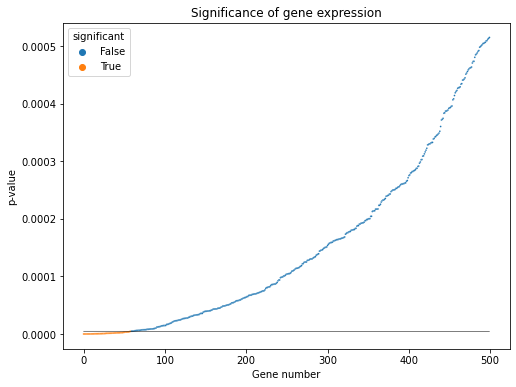

In [22]:
def plot_significance(results, threshold):
    results['number'] = range(len(results))
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.lineplot(x='number',y=threshold, data=results, ax=ax, color='black', linewidth=0.5)
    sns.scatterplot(x='number',y='p_value', hue='significant', data=results, s=3, ax=ax)
    ax.set_title('Significance of gene expression')
    ax.set_xlabel('Gene number')
    ax.set_ylabel('p-value')
    
plot_significance(holms_results.iloc[:500,:], 'holms_threshold')    

Notice the following about this plot:  
1. The p-value significance line crosses the threshold point at an apparent break point.   
2. The significant p-values are all very small since there are so many tests.

### Benamini-Hochberg FDR Control 

The Benamini-Hochberg FDR control algorithm is another way to control false discoveries. Stat with an ordered set of $n$ p-values, $D = \{ p_{(1)}, p_{(2)}, p_{(3)}, \ldots, p_{(n)} \}$ we define a false discovery rate, $q$:

$$FDR(D) \le q$$

The cutoff threshold for the ith p-value is then:
$$p_{(i)} \le Threshold(D_q) = \frac{q}{n} i$$

> **Exercise 01-9:** In this exercise you will apply the Benamini-Hochberg FDR control algorithm for testing the significance of the gene expressions. The `BH_significance` function is quite similar to the Holm's method function you have already created. Given the large number of genes you must use a low false discovery rate, $0.001$, or 1 out of 1,000. 
> Execute your function, saving the result. Then print the number of significant cases. 

In [29]:
def BH_significance(test_results, false_discovery_tollerance):
    ## First compute the thresholds for each of the ordered tests
    ## Put your code below. 
    n_tests = len(test_results)
    multiplier = list(range(n_tests))
    test_results['bh_threshold'] = np.multiply(false_discovery_tollerance/n_tests, multiplier)
    ## Now we test the significance of the ordered p-values 
    test_results['significant'] = test_results.iloc[:,1] < test_results.loc[:,'bh_threshold']
    return test_results

BH_results = BH_significance(gene_statistics, 0.001)    
len(BH_results.loc[BH_results.loc[:,'significant'],:])

70

> The result is similar to the first two FDR control methods. Given the false discovery parameter of 0.0001 do you think this is a reasonable result? 

Finally, execute the code in the cell below and examine the resulting plot.

C:\USERS\STEVEPC2\ANACONDA3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


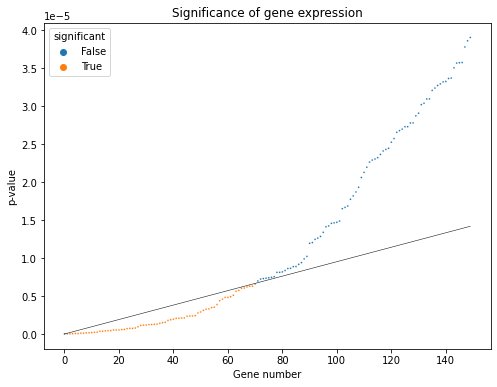

In [31]:
plot_significance(BH_results.iloc[:150,:], 'bh_threshold')    

> **Exercise 01-10**: Compare the plot above to the foregoing plot for Holm's method. Are the breaks in slope of the p-value curve at the crossing point with the threshold values reasonable in both cases? 

##### Copyright 2021, Stephen F. Elston. All rights reserved. 